Combined Estimators

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn import linear_model, decomposition,datasets

In [4]:
from sklearn.pipeline import Pipeline

In [5]:
from sklearn.model_selection import GridSearchCV

In [6]:
logistic = linear_model.LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline(steps = [('pca', pca), ('logistic', logistic)])

In [7]:
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [8]:
pca.fit(X_digits)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
%matplotlib inline

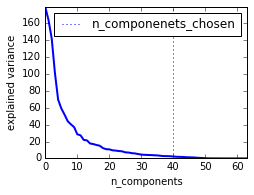

In [19]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth = 2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained variance')
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)
estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, logistic__C=Cs))
estimator.fit(X_digits, y_digits)
plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components, linestyle=":", label="n_componenets_chosen")
plt.legend(prop=dict(size=12))
plt.show()

Face Recognition with Eigenfaces

In [36]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [24]:
print(__doc__)

Automatically created module for IPython interactive environment


In [25]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [26]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape

In [27]:
X=lfw_people.data
n_features = X.shape[1]

In [28]:
n_features

1850

In [29]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total Dataset Size:")
print("Samples %d" % n_samples)
print("Features %d" % n_features)
print("Classes %d"% n_classes)

Total Dataset Size:
Samples 1288
Features 1850
Classes 7


In [30]:
1288 * 1850

2382800

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
n_components = 150
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

Extracting the top 150 eigenfaces from 966 faces


In [39]:
t0  = time()
pca =PCA(n_components = n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("Done in %0.3fs" % (time() - t0))
eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Done in 0.203s
Projecting the input data on the orthonormal basis
done in 0.016s


In [40]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C':[1e3, 5e3, 1e4, 5e4, 1e5],
             'gamma':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Done in %0.3fs"%(time()-t0))

Fitting the classifier to the training set
Done in 23.634s


In [41]:
print("Best Estimator Found By Grid Search")
print(clf.best_estimator_)

Best Estimator Found By Grid Search
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [42]:
print("Predicting People's Names on the Test Set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("Done in %0.3fs"%(time() - t0))

Predicting People's Names on the Test Set
Done in 0.062s


In [43]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred,labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.54      0.61        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.89      0.63      0.74        27
    George W Bush       0.84      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       1.00      0.81      0.89        36

      avg / total       0.87      0.86      0.85       322

[[  7   1   0   5   0   0   0]
 [  1  52   1   6   0   0   0]
 [  2   2  17   6   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   4  20   0   0]
 [  0   4   0   2   1   8   0]
 [  0   1   1   5   0   0  29]]


In [49]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.55)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [55]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    truth_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'pred: %s \ntruth: %s'%(pred_name, truth_name)

In [56]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                    for i in range(y_pred.shape[0])]

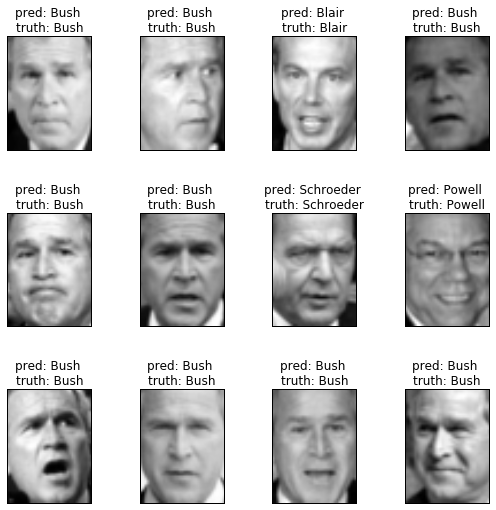

In [57]:
plot_gallery(X_test, prediction_titles, h, w)

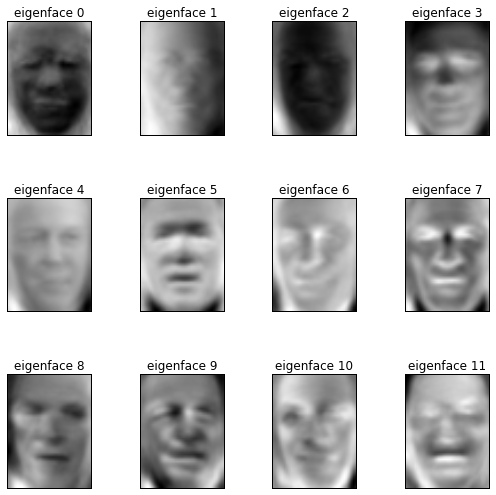

In [58]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()